# Spatial clustering of CODEX spatial proteomics data
This tutorial shows an example of spatial clustering of a CODEX dataset of mouse spleens from [Goltsev et al., 2018](https://doi.org/10.1016/j.cell.2018.07.010) using CellCharter.
The dataset is composed of 3 healthy samples (BALBc-1 to BALBc-3) and 6 samples from mice with the systmeic lupus erythematosus disease (MRL-4 to MRL-9) for a total of more than 700k cells assyed for around 30 protein markers. <br>
We are going to use trVAE for dimensionality reduction and CellCharter to compute the spatial clusters of all samples together.

## Data preprocessing
Let's first load the packages that will be necessary for the analysis.

In [1]:
import anndata as ad
import squidpy as sq
import cellcharter as cc
import pandas as pd
import torch
import scanpy as sc
from matplotlib import cm

Validation errors in config file(s).
The following fields have been reset to the default value:

application -> window_maximized
  none is not an allowed value (type=type_error.none.not_allowed)
application -> window_fullscreen
  none is not an allowed value (type=type_error.none.not_allowed)

/home/varrone/miniconda3/envs/cellcharter-dev/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/varrone/miniconda3/envs/cellcharter-dev/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")
 captum (see https://github.com/pytorch/captum).
/home/varrone/miniconda3/envs/cellcharter-dev/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightn

We can download the full dataset directly through CellCharter.

In [3]:
adata = cc.datasets.codex_mouse_spleen()
adata

  0%|          | 0.00/152M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 707474 × 29
    obs: 'cell_type', 'i-niche', 'tile', 'area', 'dataset', 'stage', 'sample'
    uns: 'spatial', 'spatial_cluster_colors'
    obsm: 'blanks', 'spatial'

We are now going to scale the intensity values of each marker individually using scanpy's `pp.scale` function.

First, we save the unscaled data in the raw version of our anndata object, so that we can retrieve it any time.<br>
Then, each sample will be scaled indepenendently. However, scanpy does not implement this functionality, so we will do it manually.


In [4]:
adata.raw = adata.copy()
for sample in adata.obs['sample'].cat.categories:
    adata.X[adata.obs['sample'] == sample, :] = sc.pp.scale(adata[adata.obs['sample'] == sample], copy=True).X

## Dimensionality reduction


Given the limited number of markers in current spatial proteomics technologies, dimensionality reduction is not stricly necessary. However, we noticed that it can help in reducing noise and speed up the clustering step. This is crucial especially in the cluster stability analysis, that, to suggest the best candidates for the number of clusters, repeats the clustering multiple times.

Since the focus of this tutorial is on CellCharter's spatial clustering, we are going to use a trVAE model already pretrained on this dataset.<br>
If you want to train the model yourself because, for example, you want to apply it to a different dataset, you can check the final section of this tutorial.
First we load the model. In `map_location` you can specify the device in which you want to load the model. This allows to load, for example, to load on CPU a model trained on a GPU.
In fact, this model was trained on a GPU, but we are going to load it on the CPU.


In [5]:
model = cc.tl.TRVAE.load('./tutorial_models/codex_mouse_spleen_trvae', adata, map_location='cpu')

AnnData object with n_obs × n_vars = 707474 × 29
    obs: 'cell_type', 'i-niche', 'tile', 'area', 'dataset', 'stage', 'sample'
    uns: 'spatial', 'spatial_cluster_colors'
    obsm: 'blanks', 'spatial'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 29 128 1
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 1
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 29 



Then we are going to extract the dimensionality-reduced embeddings for all cells of the dataset. We use the `dataset` labels, which are the same for all cells of this dataset, as condition, because there was no need to correct for batch effects.


In [6]:
adata.obsm['X_trVAE'] = model.get_latent(adata.X, adata.obs['dataset'])

## CellCharter's spatial clustering
It's now time to compute the spatial clusters.<br>
CellCharter encodes all cells of each sample as a network. Every cell is a node and two cells are connected by an edge if they are physically close to each other in the tissue.
We can obtain this network using squidpy's `gr.spatial_neighbors` function.

In [7]:
sq.gr.spatial_neighbors(adata, library_key='sample', coord_type='generic', delaunay=True)

However, the Delaunay triangulation used by squidpy has the drawback of generating connections between distant cells.<br>
We can see it by zooming in one area of the BALBc-3 sample.

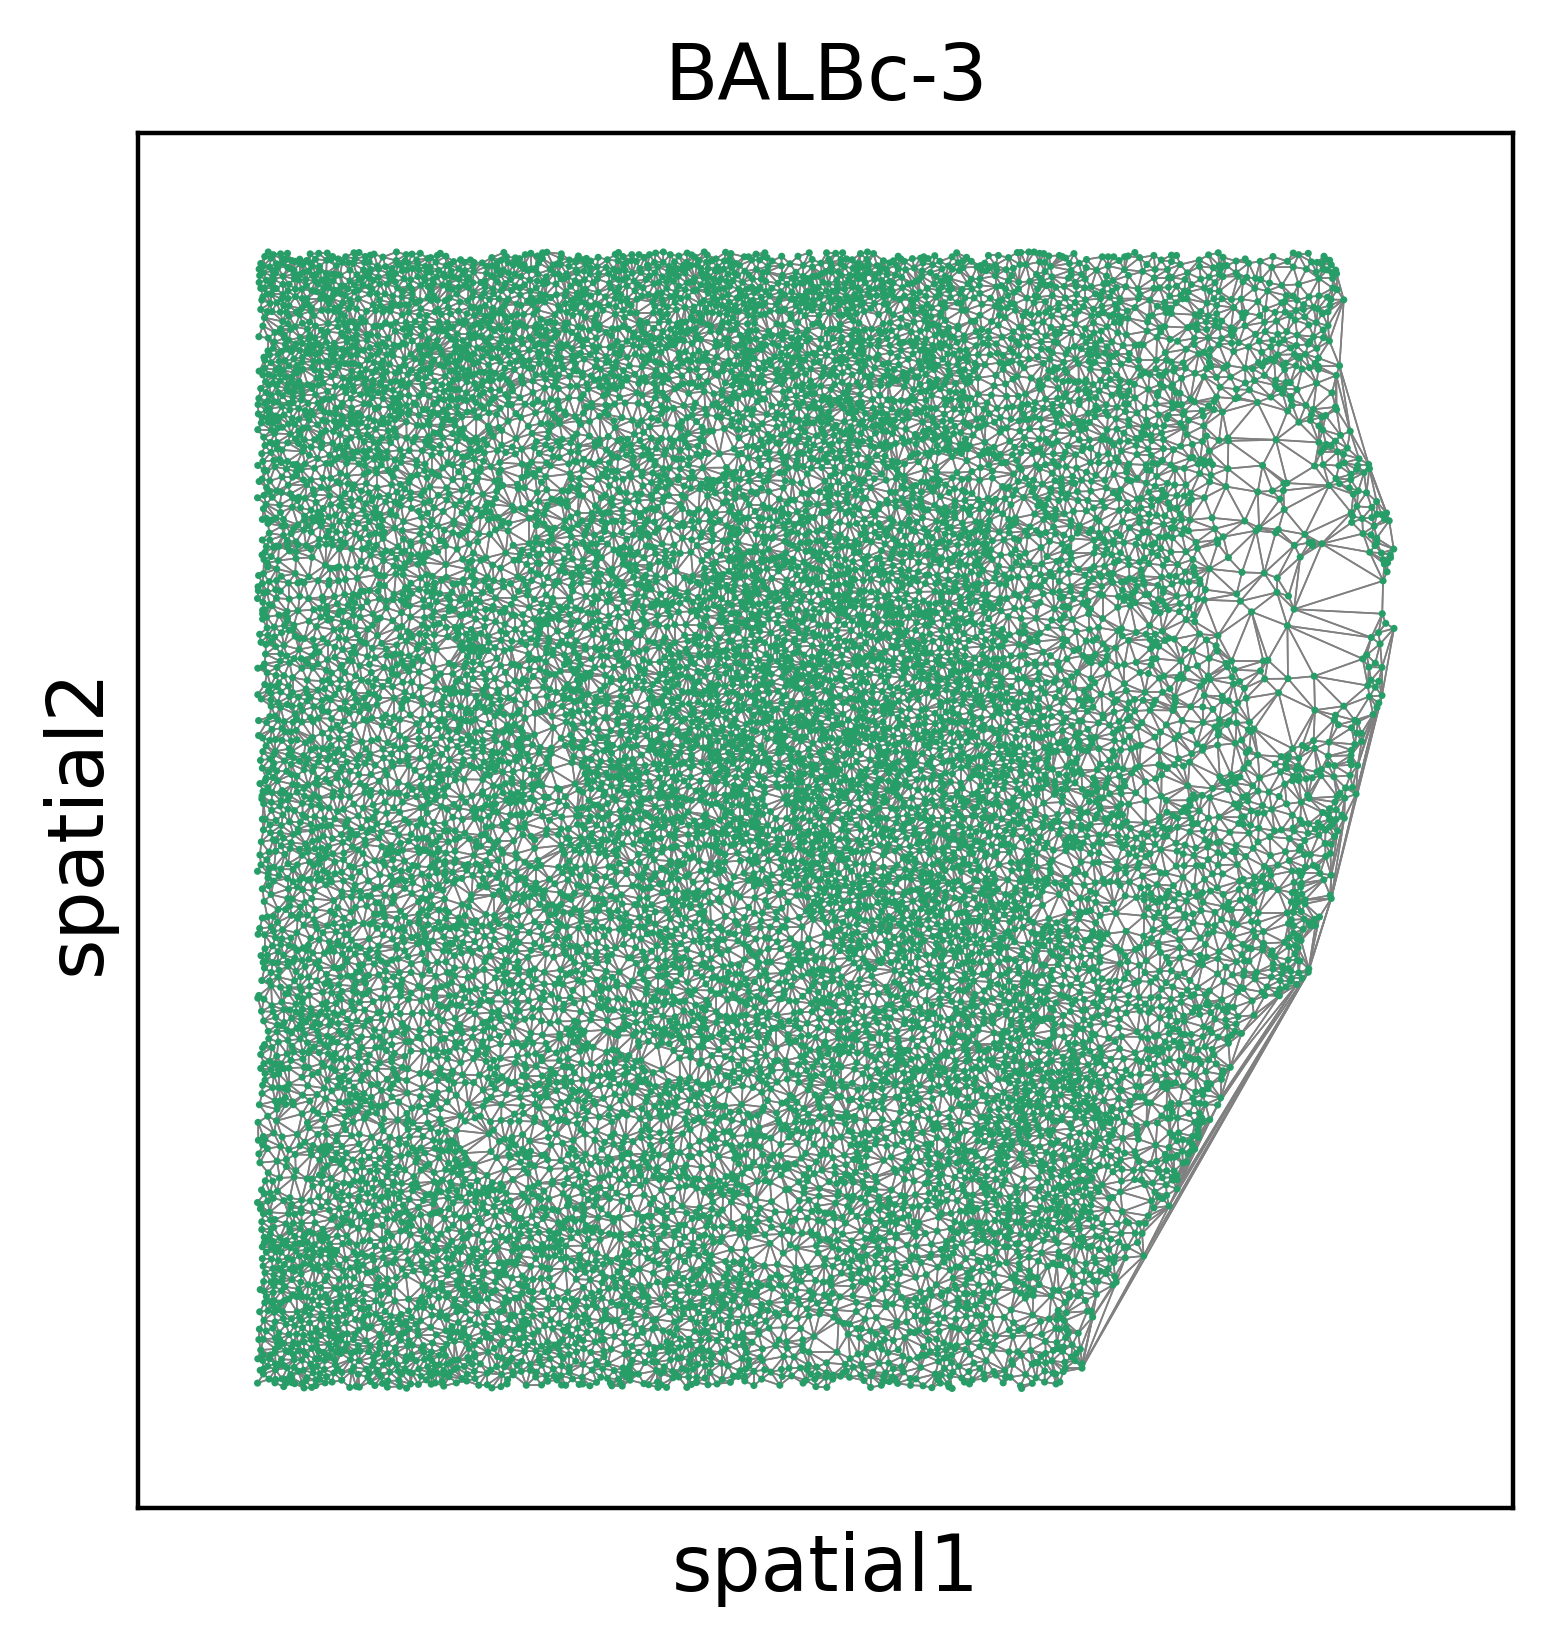

In [9]:
sq.pl.spatial_scatter(
    adata, 
    color='sample', 
    library_key='sample', 
    img=None, 
    title=['BALBc-3'],
    size=2500,
    connectivity_key='spatial_connectivities',
    edges_width=0.3,
    legend_loc=None,
    crop_coord=(900000, 900000, 1700000, 1700000 ),
    library_id=['BALBc-3']
    )

One could decide a maximum radius and pass it as a parameter to the function, but it depends from dataset to dataset based on the spatial resolution of the data. We developed a method called gr.remove_longLinks that removes links that have a distance greater than a certain percentile (the default is the 99th percentile). We can see that it greatly reduces the long links without affecting the rest.

In [10]:
cc.gr.remove_long_links(adata)

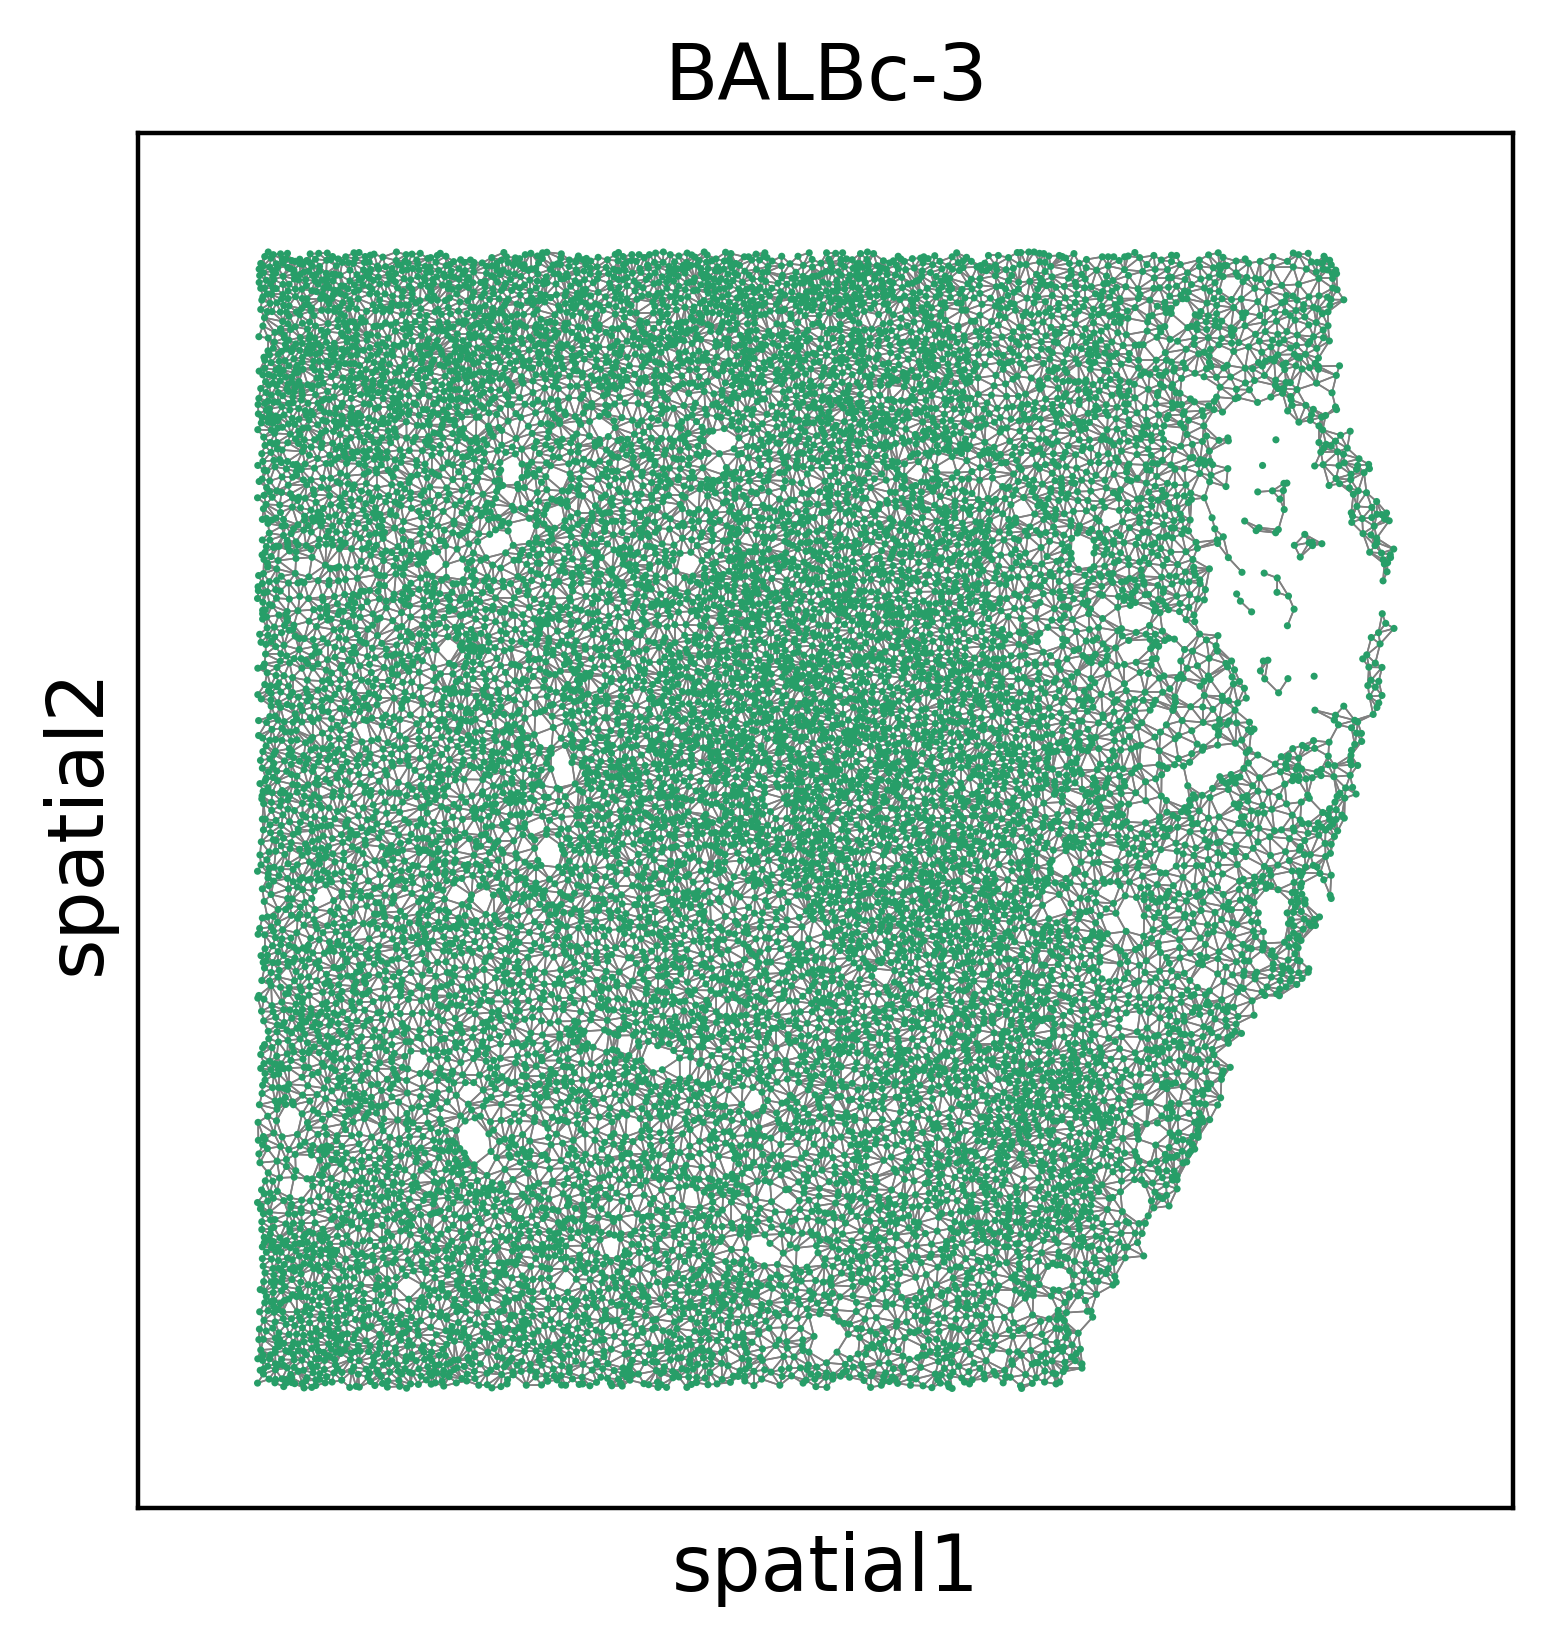

In [11]:
sq.pl.spatial_scatter(
    adata, 
    color='sample', 
    library_key='sample', 
    img=None, 
    title=['BALBc-3'],
    size=2500,
    connectivity_key='spatial_connectivities',
    edges_width=0.3,
    legend_loc=None,
    crop_coord=(900000, 900000, 1700000, 1700000 ),
    library_id=['BALBc-3']
    )

The next step is the neighborhood aggregation. It consists of concatenating the features of every cell with the features aggregated from neighbors ad increasing layers from the considered cell, up to a certain layer `n_layers`. Aggregation functions are used to obtain a single feature vector form the vectors of multiple neighbors, with the default being the `mean` function.

In this case we use 3 layers of neighbors, so we obtain, for each cell, a feature vector of length 40. That is the cell's reduced vector size from trVAE (10) plus the 3 aggregated vectors of length 10 each, from the 3 layers of neighbors.

In [12]:
cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='X_trVAE')

  0%|          | 0/9 [00:00<?, ?it/s]

We create the Gaussian Mixture model, specifying 11 as desired number of clusters. This value was obtained from the cluster stability analysis. For more details, you can check our paper.

In [ ]:
gmm = cc.tl.Cluster(n_clusters=11, random_state=12345)

Then we fit the model to the data and predict the cluster label of all cells.

In [ ]:
gmm.fit(adata, use_rep='X_cellcharter')
adata.obs['spatial_cluster'] = gmm.predict(adata, use_rep='X_cellcharter')

We can visualize the spatial clusters for some samples. In this case, we chose a healthy sample, and samples from the early, intermediate and late stage.

In [ ]:
sq.pl.spatial_scatter(
    adata, 
    color='spatial_cluster', 
    library_key='library_id', 
    img=None, 
    title=['BALBc-1', 'MRL-4 (early)', 'MRL-8 (intermediate)', 'MRL-9 (late)'],
    size=2500,
    ncols=2,
    library_id=['BALBc-1', 'MRL-4', 'MRL-8', 'MRL-9']
    )